In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
import string
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

'cuda:0'

## Resumen:

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (test=0.581, aunque no se fijó la semilla y no se puede reproducir).

## Preprocesamiento

In [3]:
from utils import (color_toxic_words, remove_symbols, completely_toxic, separate_words, 
                   get_index_toxic_words, f1)

In [4]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [5]:
train['spans_clean'] = train['spans']

In [6]:
# Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

In [7]:
# Quitamos símbolos

indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

In [8]:
# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

## Cargar embeddings

Checar [Deep Learning For NLP with PyTorch and Torchtext](https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f).

In [22]:
from torchtext.vocab import GloVe

GloVe(name='twitter.27B')

.vector_cache/glove.twitter.27B.zip: 1.52GB [49:30, 512kB/s]                                


RuntimeError: no vectors found at .vector_cache/glove.twitter.27B.300d.txt

In [23]:
GloVe.url

{'42B': 'http://nlp.stanford.edu/data/glove.42B.300d.zip',
 '840B': 'http://nlp.stanford.edu/data/glove.840B.300d.zip',
 'twitter.27B': 'http://nlp.stanford.edu/data/glove.twitter.27B.zip',
 '6B': 'http://nlp.stanford.edu/data/glove.6B.zip'}

In [24]:
from torchtext.data import Field


text_field = Field(
    tokenize='basic_english', 
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))

/home/david/Documentos/PyTorch-1.x/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [26]:
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

100%|█████████▉| 1193513/1193514 [01:18<00:00, 15264.44it/s]


In [27]:
vocab

In [28]:
vocab.lookup_indices(['another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'us', 'citizen', '....', 'sarcasm'])

[126, 1322, 6, 3243, 2117, 412, 7, 796, 6, 1014, 85, 1085, 0, 3944]

In [30]:
from torch.utils.data import Dataset, DataLoader


class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        score = np.array(self.df.iloc[idx, 0]).reshape(1, -1)
        features = np.array(self.df.iloc[idx, 1:]).reshape(1, -1)
        
        sample = {'features': features, 'score': score}

        return sample

## LSTM

In [31]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens))

In [32]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens))

In [33]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)
def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [34]:
"""
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:              # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
"""            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [35]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, weight, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Usar otro embedding, tratar con alguno que haya en 'transformers'
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [36]:
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words)
        tag_scores = model(inputs)
        tags = [np.argmax(x.cpu().numpy()) for x in tag_scores]

        tagged_sentence = [(word, ix_to_tag[tag]) for word,tag in zip(words, tags)]

    return tagged_sentence

def f1_scores(df):
    scores_LSTM = []
    for gold_index, text in df.values:
        tagged_sentence = tagger_LSTM(text)   
        prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
        scores_LSTM.append(f1(prediction_index, gold_index))
        
    return np.mean(scores_LSTM)

def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=True):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    if show:
        plt.show()

In [41]:
HIDDEN_DIM = 30
embedding_dim = 200
model = LSTMTagger(embedding_dim, vocab.vectors, HIDDEN_DIM, len(vocab.vectors), len(tag_to_ix))
model.to(torch.device(dev))

LSTMTagger(
  (word_embeddings): Embedding(20566, 200)
  (lstm): LSTM(200, 30)
  (hidden2tag): Linear(in_features=30, out_features=2, bias=True)
)

In [42]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-7)
#optimizer = optim.Adam(model.parameters(), weight_decay=1e-6)

In [43]:
loss_per_epoch = [0]
training_loss = [0]
f1_scores_train = [0]
f1_scores_dev = [0]
stop_after_best = 100
best_l = None
best_tl = None
worst_l = 0
worst_tl = 0
worst_l_f1 = 0
best_l_f1 = None
worst_tl_f1 = 0
last_epoch_save = 0

###############################################
Current epoch: 174
Last model save was in epoch 132
Stopping training in: 59 epochs.
###############################################
[Best iter] test F1 is: 0.6116178919674846
[Best iter] dev F1 is: 0.6018780659127985
###############################################
[Last iter] training F1 was: 0.6119289838956861
[Last iter] dev. F1 was: 0.5860561203571637
###############################################


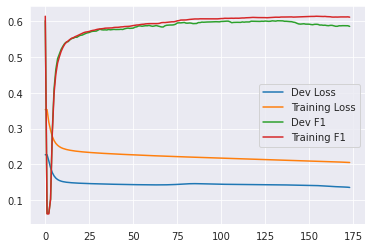

Sentence 0 done.
Sentence 1000 done.
Sentence 2000 done.
Sentence 3000 done.
Sentence 4000 done.
Sentence 5000 done.
Sentence 6000 done.
Sentence 7000 done.


KeyboardInterrupt: 

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

stop_after_best = 100
#Nombre del archivo de backup
savefile = 'best-model.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 100 épocas
    display.clear_output(wait=True)
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] test F1 is: " + str(best_tl))
    print("[Best iter] dev F1 is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training F1 was: " + str(f1_scores_train[-1]))
    print("[Last iter] dev. F1 was: " + str(f1_scores_dev[-1]))
    print("###############################################")
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_scores_dev)
    plt.plot(range(epochs), f1_scores_train)
    plt.legend(["Dev Loss", "Training Loss", "Dev F1", "Training F1"])
    plt.show()
    tl = 0
    for i, v in enumerate(train_data):
        sentence, tags = v
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        optimizer.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.

        sentence_in = prepare_sequence(sentence)
        targets = prepare_sequence_tags(tags) 

        #print(targets)
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()

        loss = criterion(tag_scores, targets)
        tl += loss.item()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Sentence {} done.".format(i))
    tl /= len(train_data)
    l = 0
    #evaluar el modelo
    model.eval()
    with torch.no_grad():
        for sentence, tags in test_data:
            sentence_in = prepare_sequence(sentence)
            targets = prepare_sequence_tags(tags) 

            tag_scores = model(sentence_in)

            loss_test = criterion(tag_scores, targets)
            l += loss_test.item()
    model.train()
    l /= len(test_data)
    
    f1_t = f1_scores(train[['spans', 'text']])
    f1_d = f1_scores(test[['spans', 'text']])
    
    epochs_without_change += 1
    if best_l is None or best_l < f1_d:
        torch.save(model, savefile)
        best_l = f1_d
        best_tl = f1_t
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    #Para graficar con una escala coherente.
    if(f1_d > worst_l_f1):
        worst_l_f1 = f1_d
        f1_scores_dev[0] = worst_l_f1
    if(f1_t > worst_tl_f1):
        worst_tl_f1 = f1_t
        f1_scores_train[0] = worst_tl_f1
    if(tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl
    if(l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_scores_train.append(f1_t)
    f1_scores_dev.append(f1_d)
    #Rastreo la época actual
    epochs += 1
print('Finished Training')

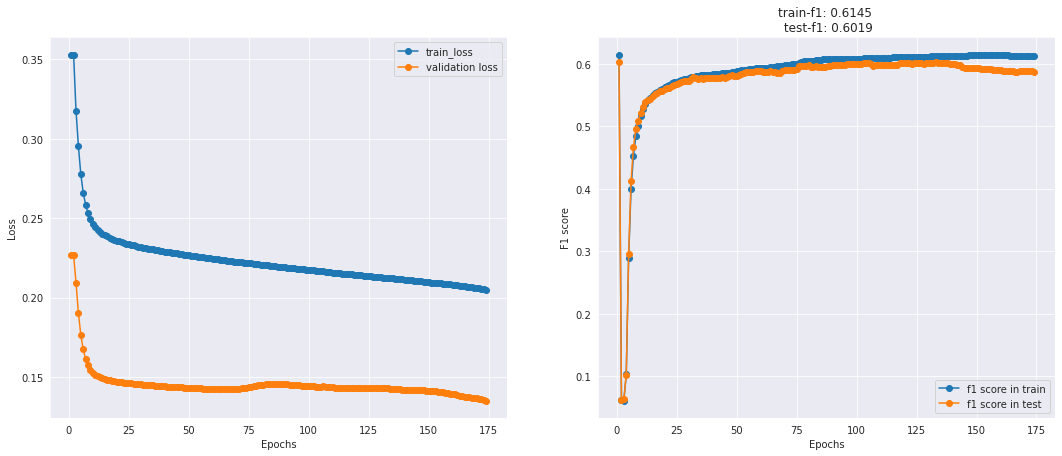

In [48]:
plot_loss_and_score(training_loss, loss_per_epoch, f1_scores_train, f1_scores_dev, show=False)
plt.title('train-f1: {:.4f} \n test-f1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_dev)))
plt.savefig('Images/preprocesamiento-4.png', bbox_inches='tight')
plt.show()

## Evaluación

In [ ]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

In [ ]:
indices_evaluation = []
for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
#     print(colored('Pred: ', color='cyan', attrs=['bold']) + 
#           color_toxic_words(prediction_index, text)) 

In [ ]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [ ]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 